<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 8: Classification Methods</h2></center>
<br>

In this tutorial we study how to implement a range of classification methods in Python.  We use the customer relationship management (CRM) dataset that we first saw in the linear model selection and regularisation tutorial. 

<a class="buttom" href=">#Data:-customer-acquisition">Data: customer acquisition</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Feature-processing">Feature processing</a> <br>
<a class="buttom" href="#Logistic-regression">Logistic regression</a> <br>
<a class="buttom" href="#Gaussian-discriminant-analysis">Gaussian discriminant analysis</a> <br>
<a class="buttom" href="#K-nearest-neighbours-classifier">K-nearest neighbours classifier</a> <br>
<a class="buttom" href="#Model-evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline

##Data: customer acquisition

In [2]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121


We process the data as follows. Note only that five of the variables in the dataset (including the response) are relevant for customer acquisition modelling, since the rest are variables measured only after a customer is acquired.

In [3]:
train = data.sample(frac=0.7, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

response = 'Acquisition'
predictors = ['Acq_Expense', 'Revenue', 'Employees', 'Industry']

y_train = train[response]
y_test = test[response]
X_train = train[predictors]
X_test = test[predictors]

##Exploratory data analysis

The company acquired 58.9% of prospects in the training data as customers. 

In [4]:
round(y_train.mean(), 3)

0.589

The next cell display the descriptive statistics for the predictors. We add the sample skewness and kurtosis to the table to verify how close the empirical distribution of numerical predictor is from the normal distribution. 

The acquisition expense and revenue are approximately symmetric, but seem to have lower kurtosis (thinner tails) that a normally distributed variable. The number of employees variable is positively skewed and also displays low kurtosis. 

57.4% of prospects are in the B2B (business-to-business) industry.  

In [5]:
descriptive = X_train.describe()
descriptive.loc['skew', :] = X_train.skew()
descriptive.loc['kurt', :] = X_train.kurt()
descriptive.round(3)

,Acq_Expense,Revenue,Employees,Industry
count,350.000,350.000,350.000,350.000
mean,516.208,39.771,682.354,0.574
std,222.419,15.986,482.459,0.495
min,14.210,2.350,11.000,0.000
25%,355.335,28.062,277.250,0.000
50%,529.195,40.550,594.500,1.000
75%,688.248,51.048,1039.750,1.000
max,968.060,74.970,1950.000,1.000
skew,-0.030,-0.097,0.578,-0.302
kurt,-0.831,-0.644,-0.782,-1.920


We use histograms to further explore the univariate distribution of the numerical predictors. 

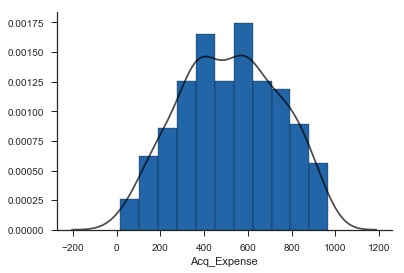

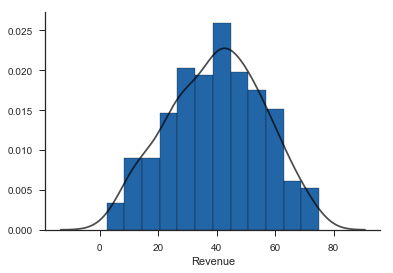

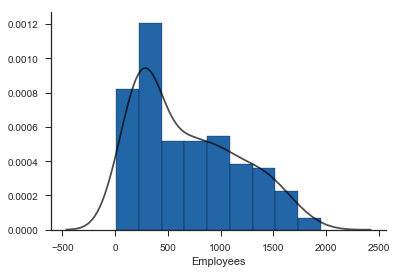

In [6]:
def hist(series):
    fig, ax= plt.subplots()
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    return fig, ax

for i in range(3):
    hist(train[predictors[i]])
    sns.despine()
    plt.show()

To explore the relationship between the numerical predictors are the respose, we use univariate logistic regression. The results that the acquisition expense may be strongly associated with a higher probability of acquisition. 

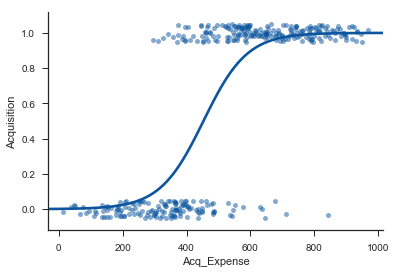

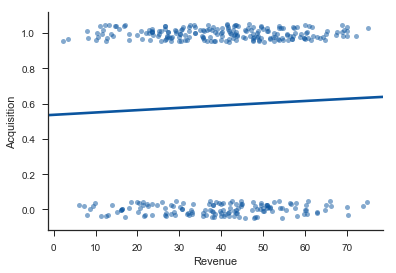

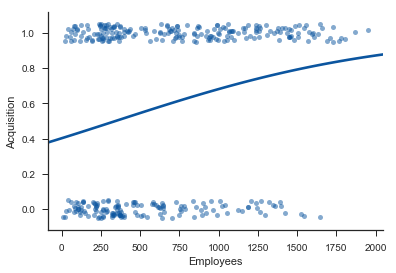

In [7]:
for i in range(3):
    sns.regplot(X_train[predictors[i]], y_train, color=sns.color_palette('Blues')[-1], ci=None, logistic=True, y_jitter=0.05, 
            scatter_kws={'s': 25, 'color': sns.color_palette('Blues')[-1], 'alpha': .5})
    sns.despine()
    plt.show()

A higher proportion of prospects is the B2B is acquired compared to the non-B2B prospects. 

In [8]:
table=pd.crosstab(train['Acquisition'], train['Industry'])
table = (table/table.sum()).round(3)
table

Industry,0,1
Acquisition,,
0,0.463,0.373
1,0.537,0.627


##Predictor processing

In this tutorial, the only processing step that apply to the predictors is to standardise the variables. Predictive transformation may be useful in some cases for classification, but cross validation suggested that it is not useful for the current application. 

In [9]:
mu=X_train.mean()
sigma=X_train.std()

X_train=(X_train-mu)/sigma
X_test=(X_test-mu)/sigma

##Logistic regression

The next two cells shows two ways of estimating logistic regressions.  The first uses the <TT>statmodels</TT> package and is useful for generating an output and interpreting the model. The second uses the <TT>scikit-learn</TT> library as usual. 

In [10]:
glm = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(glm.summary())

Optimization terminated successfully.
         Current function value: 0.207775
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            Acquisition   No. Observations:                  350
Model:                          Logit   Df Residuals:                      345
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Oct 2017   Pseudo R-squ.:                  0.6933
Time:                        14:45:20   Log-Likelihood:                -72.721
converged:                       True   LL-Null:                       -237.08
                                        LLR p-value:                 6.886e-70
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3877      0.271      5.123      0.000       0.857       1.919
Acq_Expense     4.9685    

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression
logit = LogisticRegression()
logit.fit(X_train, y_train)

# L-1 Regularised logistic regression
logit_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logit_l1.fit(X_train, y_train)

# L-2 Regularised logistic regression
logit_l2 = LogisticRegressionCV(penalty='l2')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

##Gaussian discriminant analysis

Since GDA replies on the assumption of normality, we exclude the binary predictor for this class of models. 

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train.iloc[:,:3], y_train)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train.iloc[:,:3], y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

For regularisation, we need to write a routine to select the hyperparameter by cross validation.

In [14]:
from sklearn.model_selection import cross_val_score

def qda_cv(X_train, y_train):
    
    alphas  = np.linspace(0, 1, 21)
    best_score = -np.inf
    
    for alpha in alphas:
        qda = QuadraticDiscriminantAnalysis(reg_param=alpha)
        score = np.mean(cross_val_score(qda, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = qda
            best_score = score
    
    return qda.fit(X_train, y_train)
        
qda_reg = qda_cv(X_train.iloc[:,:3], y_train) 

##K-nearest neighbours classifier

For the KNN classifier, we also need to write a routine to select te number of neighbours by cross validation.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cv(X_train, y_train):
    
    neighbours = np.arange(1, 51)
    best_score = 0
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors = k ,  metric='mahalanobis', metric_params={'V': X_train.cov()})
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = knn
            best_score = score
    
    return best
        
knn = knn_cv(X_train, y_train) 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='mahalanobis',
           metric_params={'V':              Acq_Expense   Revenue  Employees  Industry
Acq_Expense     1.000000 -0.059305   0.023439  0.075623
Revenue        -0.059305  1.000000  -0.003835 -0.162085
Employees       0.023439 -0.003835   1.000000  0.036652
Industry        0.075623 -0.162085   0.036652  1.000000},
           n_jobs=1, n_neighbors=12, p=2, weights='uniform')

##Model evaluation

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['KNN','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 


methods=[knn, logit, logit_l1, logit_l2, lda, qda, qda_reg]

for i, method in enumerate(methods):
    
    if i < 4:
        y_pred = method.predict(X_test)
        y_prob = method.predict_proba(X_test)
    else:
        y_pred = method.predict(X_test.iloc[:,:3])
        y_prob = method.predict_proba(X_test.iloc[:,:3])
    
    confusion  = confusion_matrix(y_test, y_pred) 
    error_rate =  1 - accuracy_score(y_test, y_pred)

    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  np.sqrt(error_rate*(1- error_rate)/len(y_test))
    results.iloc[i,2]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,3]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  roc_auc_score(y_test, y_prob[:,1])
    results.iloc[i,5]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,SE,Sensitivity,Specificity,AUC,Precision
KNN,0.127,0.027,0.895,0.844,0.954,0.885
Logistic,0.080,0.022,0.930,0.906,0.963,0.930
L1 regularised,0.087,0.023,0.907,0.922,0.962,0.940
L2 regularised,0.080,0.022,0.930,0.906,0.964,0.930
LDA,0.093,0.024,0.907,0.906,0.966,0.929
QDA,0.087,0.023,0.919,0.906,0.964,0.929
Regularised QDA,0.067,0.020,0.965,0.891,0.968,0.922


Except for the KNN method, all models have very similar ROC curves. 

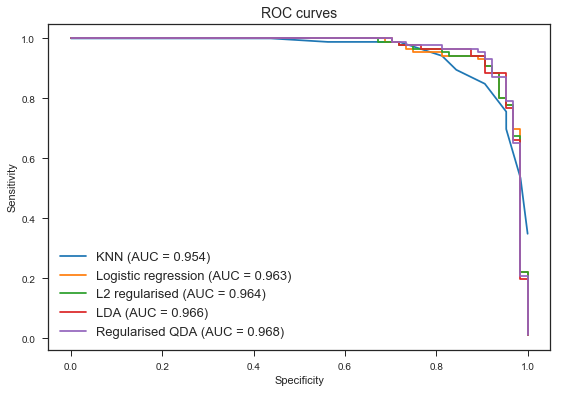

In [17]:
palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD']

from sklearn.metrics import roc_curve

labels=['KNN', 'Logistic regression', 'L2 regularised', 'LDA', 'Regularised QDA']
methods=[knn, logit, logit_l2, lda, qda_reg]

fig, ax= plt.subplots(figsize=(9,6))

for i, method in enumerate(methods):
    if i < 3:
        y_prob = method.predict_proba(X_test)
    else:
        y_prob = method.predict_proba(X_test.iloc[:,:3])
        
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    auc = roc_auc_score(y_test, y_prob[:,1])
    ax.plot(1-fpr, tpr, label=labels[i] + ' (AUC = {:.3f})'.format(auc), color = palette[i])
    
ax.set_xlabel('Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC curves', fontsize=14)
plt.legend(fontsize=13)
plt.show()
